# Gated Recurrent Unit (GRU) Implementation from Scratch in PyTorch


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import os
import random
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


# Hyperparameters

In [2]:
hyperparameters = {
    'lags': 9,
    'forecast': 1,
    'input_features_size': 1,
    'hidden_features_size': 256,
    'output_features_size': 1,
    'num_layers': 6,
    'batch_size': 32,
    'split_ratio': 0.8, # 80% training, 20% testing
    'learning_rate': 0.001,
    'num_epochs': 150,
}

hyperparameters['window_size'] =  hyperparameters['lags'] + hyperparameters['forecast']

# Dataset

In [3]:
# Airline Passgeners
df_full = pd.read_csv('data/airline_passengers/airline-passengers.csv')
df_full.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df_full['Month'] = pd.to_datetime(df_full['Month'])
df_full.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [5]:
df_full.set_index('Month', inplace=True)
df_full.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

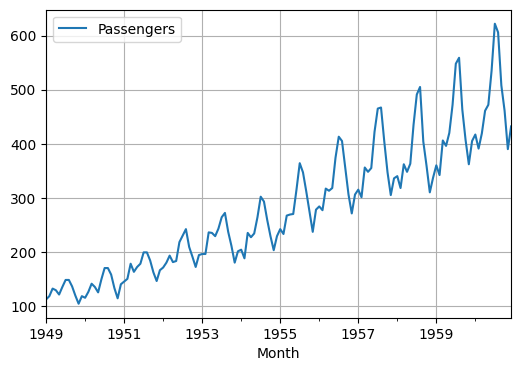

In [6]:
df_full.plot()

# Standart Scaler
* Exercise: Try without scaler, see if learning works!

<Axes: xlabel='Month'>

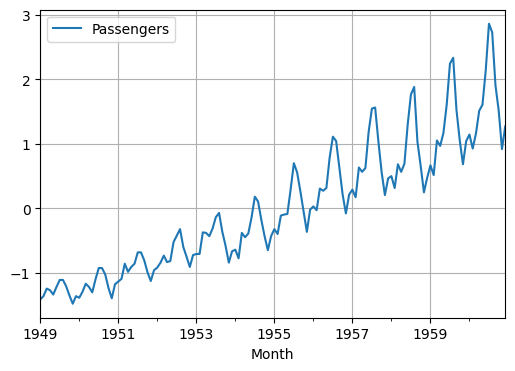

In [7]:
scaler = StandardScaler()

df_full['Passengers'] = scaler.fit_transform(df_full['Passengers'].values.reshape(-1, 1))
df_full.plot()

### Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [8]:
df_full.shape

(144, 1)

# Model
## GRU Cell
$r_t = \sigma(W_{ir}x_t + b_{ir} + W_{hr}h_{t-1} + b_{hr})$

$z_t = \sigma(W_{iz}x_t + b_{iz} + W_{hz}h_{t-1} + b_{hz})$

$n_t = tahn(W_{in}x_t + b_{in} + r_t \odot (W_{hn}h_{t-1} + b_{hn}))$

$h_t = (1-z_t) \odot n_t + z_t \odot h_{t-1}$

In [9]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.W_ir = nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hr = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_r = nn.Parameter(torch.randn(hidden_size))
        
        self.W_iz = nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hz = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_z = nn.Parameter(torch.randn(hidden_size))
        
        self.W_in = nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hn = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_n = nn.Parameter(torch.randn(hidden_size))
        
        self._init_parameters()
    
    def _init_parameters(self):
        nn.init.xavier_uniform_(self.W_ir)
        nn.init.xavier_uniform_(self.W_hr)
        nn.init.constant_(self.b_r, 0)
        
        nn.init.xavier_uniform_(self.W_iz)
        nn.init.xavier_uniform_(self.W_hz)
        nn.init.constant_(self.b_z, 0)
        
        nn.init.xavier_uniform_(self.W_in)
        nn.init.xavier_uniform_(self.W_hn)
        nn.init.constant_(self.b_n, 0)
    
    def forward(self, x, h):
        # RESET GATE
        r = torch.sigmoid(torch.matmul(x, self.W_ir) + torch.matmul(h, self.W_hr) + self.b_r)
        # UPDATE GATE
        z = torch.sigmoid(torch.matmul(x, self.W_iz) + torch.matmul(h, self.W_hz) + self.b_z)
        # NEW GATE
        n = torch.tanh(torch.matmul(x, self.W_in) + r*torch.matmul(h, self.W_hn) + self.b_n)
        # Decide whether to keep old values or new ones
        h_new = (1 - z)*n + z*h
        return h_new

## GRU Model

In [10]:
class GRU(nn.Module):
    def __init__(self, input_features, hidden_features):
        super(GRU, self).__init__()

        self.hidden_features = hidden_features
        
        self.gru_cell = GRUCell(input_features, hidden_features)

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_features)
    
    def forward(self, x, h):
        # (hyperparameters['batch_size'], hyperparameters['lags'], FEATURES)
        seq_len = x.shape[1]

        output_history = []

        # loop through seqeunce of time series features
        for i in range(seq_len):
            # x[:, i, :] -> # (hyperparameters['batch_size'], FEATURES)
            h = self.gru_cell(x[:, i, :], h)

            # Add dummy sequence dimension (required to concat)
            # (hyperparameters['batch_size'], FEATURES) -> (hyperparameters['batch_size'], 1, FEATURES)
            output_history.append(h.unsqueeze(1))

        output = torch.cat(output_history, dim=1)
        # output: (hyperparameters['batch_size'], hyperparameters['lags'], FEATURES)
        # h (last hidden state): (hyperparameters['batch_size'], FEATURES)
        return output, h

In [11]:
gru = GRU(
    hyperparameters['input_features_size'], 
    hyperparameters['hidden_features_size']
)

In [12]:
hidden_state = torch.zeros(
    hyperparameters['batch_size'], 
    hyperparameters['hidden_features_size']
)

dummy_data = torch.randn(
    hyperparameters['batch_size'], 
    hyperparameters['lags'], 
    hyperparameters['input_features_size']
)
            
o, h = gru(dummy_data, hidden_state)
o.shape, h.shape

(torch.Size([32, 9, 256]), torch.Size([32, 256]))

# Sliding Window 
*  **NOTE: "LAGS + FORECAST = WINDOW_SIZE" MUST HOLD**

### Slide Methods

In [13]:
dummy_data = list(range(100))

# increase by 1
single_step = range(0, len(dummy_data)-hyperparameters['window_size']+1, 1)
# increase by hyperparameters['window_size']
window_step = range(0, len(dummy_data)-hyperparameters['window_size']+1, hyperparameters['window_size'])


#for start_index in single_step:
for start_index in window_step:
    print(f"Start: {start_index}, End: {start_index+hyperparameters['window_size']}")

    # Slice window from data 
    data_window = dummy_data[start_index:start_index+hyperparameters['window_size']]

    # Split current window into lags and forecast
    data_lag = data_window[:hyperparameters['lags']]
    data_forecast = data_window[-hyperparameters['forecast']:]

    print(f'Lag: {data_lag}, forecast: {data_forecast}')

Start: 0, End: 10
Lag: [0, 1, 2, 3, 4, 5, 6, 7, 8], forecast: [9]
Start: 10, End: 20
Lag: [10, 11, 12, 13, 14, 15, 16, 17, 18], forecast: [19]
Start: 20, End: 30
Lag: [20, 21, 22, 23, 24, 25, 26, 27, 28], forecast: [29]
Start: 30, End: 40
Lag: [30, 31, 32, 33, 34, 35, 36, 37, 38], forecast: [39]
Start: 40, End: 50
Lag: [40, 41, 42, 43, 44, 45, 46, 47, 48], forecast: [49]
Start: 50, End: 60
Lag: [50, 51, 52, 53, 54, 55, 56, 57, 58], forecast: [59]
Start: 60, End: 70
Lag: [60, 61, 62, 63, 64, 65, 66, 67, 68], forecast: [69]
Start: 70, End: 80
Lag: [70, 71, 72, 73, 74, 75, 76, 77, 78], forecast: [79]
Start: 80, End: 90
Lag: [80, 81, 82, 83, 84, 85, 86, 87, 88], forecast: [89]
Start: 90, End: 100
Lag: [90, 91, 92, 93, 94, 95, 96, 97, 98], forecast: [99]


# Dataset

In [14]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, lags, forecast):
        self.df = df
        self.lags = lags
        self.forecast = forecast
        self.window_size = lags + forecast
        
    def __len__(self):
        number_of_samples = self.df.shape[0]
        # make sure that last window fits
        return number_of_samples - self.window_size

    def __getitem__(self, start_idx):

        # get a NumPy array of size: (hyperparameters['window_size'], NUM_FEATURES)
        sample_window = self.df.iloc[start_idx:start_idx+self.window_size].values

        # divide window into lags and forecast:
        # (hyperparameters['lags'], NUM_FEATURES)
        lags = sample_window[:self.lags, :]
        # (hyperparameters['forecast'], NUM_FEATURES)
        forecast = sample_window[-self.forecast:, :]

        # convert to tensor
        lags = torch.tensor(lags, dtype=torch.float32)
        forecast = torch.tensor(forecast, dtype=torch.float32)
        return lags, forecast

In [15]:
dataset_full = TimeSeriesDataset(
    df_full,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

In [16]:
_lags, _forecast = dataset_full[0]
_lags.shape, _forecast.shape

(torch.Size([9, 1]), torch.Size([1, 1]))

### Train/Test Split

In [17]:
train_size = int(hyperparameters['split_ratio'] * len(dataset_full))
test_size = len(dataset_full) - train_size

train_size, test_size

(107, 27)

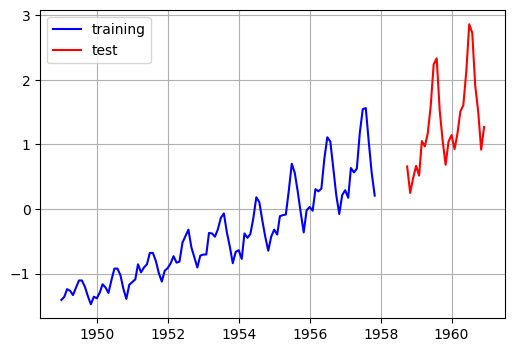

In [18]:
df_train = df_full.iloc[:train_size, :]
df_test = df_full.iloc[-test_size:, :]

plt.plot(df_train.index, df_train['Passengers'], c='blue', label='training')
plt.plot(df_test.index, df_test['Passengers'], c='red', label='test')
plt.legend()

In [19]:
dataset_train = TimeSeriesDataset(
    df_train,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

dataset_test = TimeSeriesDataset(
    df_test,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

# Dataloader

In [20]:
dataloader_full = DataLoader(
    dataset_full,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

print(f'Number of batches (total): {len(dataloader_full)}')
print(f'Number of batches (train): {len(dataloader_train)}')
print(f'Number of batches (test): {len(dataloader_test)}')

Number of batches (total): 5
Number of batches (train): 4
Number of batches (test): 1


In [21]:
_lags_batch, _forecast_batch = next(iter(dataloader_full))
# (hyperparameters['batch_size'], hyperparameters['lags'], NUM_FEATURES), # (hyperparameters['batch_size'], hyperparameters['forecast'], NUM_FEATURES)
_lags_batch.shape, _forecast_batch.shape

(torch.Size([32, 9, 1]), torch.Size([32, 1, 1]))

In [22]:
len(dataloader_full)

5

In [23]:
for idx, (s) in enumerate(dataloader_full):
    print(idx)
    print(s[0].shape, s[1].shape)

0
torch.Size([32, 9, 1]) torch.Size([32, 1, 1])
1
torch.Size([32, 9, 1]) torch.Size([32, 1, 1])
2
torch.Size([32, 9, 1]) torch.Size([32, 1, 1])
3
torch.Size([32, 9, 1]) torch.Size([32, 1, 1])
4
torch.Size([6, 9, 1]) torch.Size([6, 1, 1])


# Multilayer Autoregressive RNN

In [24]:
class AutoregressiveRNN(nn.Module):
    def __init__(self, input_features_size, hidden_features_size, output_features_size, forecast_size, num_layers):
        super().__init__()
        self.input_features_size = input_features_size
        self.hidden_features_size = hidden_features_size
        self.forecast_size = forecast_size
        self.num_layers = num_layers

        #self.input_to_hidden = nn.Linear(input_features_size, hidden_features_size)
        self.input_to_hidden = GRU(input_features_size, hidden_features_size)
        self.hidden_to_output = nn.Linear(hidden_features_size, output_features_size)

        self.rnn_layers = nn.ModuleList([
            GRU(hidden_features_size, hidden_features_size)
            for _ in range(num_layers)
        ])
    
    def forward(self, x, hidden_state=None):
        # (hyperparameters['batch_size'], hyperparameters['lags'], FEATURES)

        if hidden_state is None:
            _batch_size = x.shape[0]
            _device = x.device
            hidden_state = torch.zeros(_batch_size, self.hidden_features_size, device=_device)
        
        # Convert input features
        x, hidden_state = self.input_to_hidden(x, hidden_state)
        
        for layer in self.rnn_layers:
            x, hidden_state = layer(x, hidden_state)

        # Slice forecast
        x = x[:, -self.forecast_size:, :]
        # Convert output features
        x = self.hidden_to_output(x)
        
        return x, hidden_state

### Initialized Model with Hyperparameters

In [25]:
model = AutoregressiveRNN(
    input_features_size=hyperparameters['input_features_size'],
    hidden_features_size=hyperparameters['hidden_features_size'],
    output_features_size=hyperparameters['output_features_size'],
    forecast_size=hyperparameters['forecast'],
    num_layers=hyperparameters['num_layers']
)

#hidden_state = torch.zeros(hyperparameters['batch_size'], hyperparameters['hidden_features_size'])

o, h = model(_lags_batch)
# (hyperparameters['batch_size'], hyperparameters['forecast'], hyperparameters['hidden_features_size'])
o.shape

torch.Size([32, 1, 1])

### Number of parameters

In [26]:
def print_model_parameters(model):
    print(f'{sum(p.numel() for p in model.parameters()):,}')

In [27]:
print('Number of parameters:')
print_model_parameters(model)

Number of parameters:
2,562,305


# Training

### Training Functions

In [28]:
def train_iter(model, dataloader, optimizer, criterion, device):
    model.train()

    avg_loss = []
    
    for (lags, forecast) in dataloader:

        lags = lags.to(device)
        forecast = forecast.to(device)
        
        optimizer.zero_grad()
    
        forecast_pred, h = model(lags)
        
        loss = criterion(forecast_pred, forecast)
        
        loss.backward()
        optimizer.step()

        avg_loss.append(loss.item())

    return sum(avg_loss) / len(avg_loss)


@torch.no_grad()
def eval_iter(model, dataloader, criterion, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    for (lags, forecast) in dataloader:
        
        lags = lags.to(device)
        forecast = forecast.to(device)
        
        forecast_pred, h = model(lags)

        loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        predictions.append(forecast_pred)

    return sum(avg_loss) / len(avg_loss), predictions

### Start Training

In [29]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=hyperparameters['learning_rate']
)

# LOSS
mse_loss = nn.MSELoss()

In [30]:
model.to(device)

for epoch in range(1, hyperparameters['num_epochs']+1):
        
    avg_train_loss = train_iter(
        model=model, 
        dataloader=dataloader_train, 
        optimizer=optimizer, 
        criterion=mse_loss, 
        device=device
    )
    
    avg_test_loss, _ = eval_iter(
        model=model, 
        dataloader=dataloader_test, 
        criterion=mse_loss, 
        device=device
    )

    if epoch == 150:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Training loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}')

Epoch: 10, Training loss: 0.0821, Testing Loss: 1.0568
Epoch: 20, Training loss: 0.0794, Testing Loss: 1.7629
Epoch: 30, Training loss: 0.0361, Testing Loss: 0.8748
Epoch: 40, Training loss: 0.0399, Testing Loss: 0.8387
Epoch: 50, Training loss: 0.0284, Testing Loss: 0.4809
Epoch: 60, Training loss: 0.0306, Testing Loss: 0.3589
Epoch: 70, Training loss: 0.0340, Testing Loss: 0.7438
Epoch: 80, Training loss: 0.0259, Testing Loss: 0.4239
Epoch: 90, Training loss: 0.0246, Testing Loss: 0.3163
Epoch: 100, Training loss: 0.0247, Testing Loss: 0.4973
Epoch: 110, Training loss: 0.0221, Testing Loss: 0.3489
Epoch: 120, Training loss: 0.0404, Testing Loss: 0.4790
Epoch: 130, Training loss: 0.0242, Testing Loss: 0.4488
Epoch: 140, Training loss: 0.0190, Testing Loss: 0.3628
Epoch: 150, Training loss: 0.0441, Testing Loss: 0.2558


# Testing
* NOTE: we prefer to use single windows step during prediction

In [31]:
@torch.no_grad()
def eval_iter_single_step(model, dataloader, criterion, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    # single step
    for start_idx in range(0, len(df_test)):
        
        sample_window = df_test.iloc[start_idx:start_idx+hyperparameters['window_size'], :].values

        # covnert to tensor
        lags = torch.tensor(sample_window[:hyperparameters['lags']], dtype=torch.float32, device=device)
        forecast = torch.tensor(sample_window[-hyperparameters['forecast']:], dtype=torch.float32, device=device)

        # artificially add batch dimension
        # (we are not using the dataloader here!)
        lags = lags.unsqueeze(0)
        forecast = forecast.unsqueeze(0)

        forecast_pred, h = model(lags)

        loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        predictions.append(forecast_pred)

    return sum(avg_loss) / len(avg_loss), predictions

In [32]:
_, pred = eval_iter_single_step(
    model=model, 
    dataloader=dataloader_test, 
    criterion=mse_loss, 
    device=device
)

pred_flat = []

for p in pred:
    pred_flat.extend(p.flatten().tolist())

df_results = df_test.copy()
df_results['Prediction'] = pred_flat
df_results.head()

,Passengers,Prediction
Month,,
1958-10-01,0.658319,1.466111
1958-11-01,0.248445,2.042213
1958-12-01,0.474294,1.318782
1959-01-01,0.666684,0.892639
1959-02-01,0.516118,0.671929


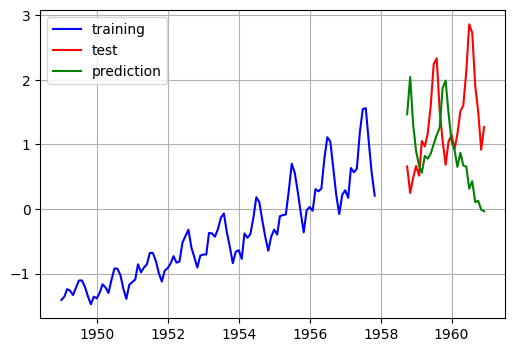

In [33]:
plt.plot(df_train.index, df_train['Passengers'], c='blue', label='training')
plt.plot(df_results.index, df_results['Passengers'], c='red', label='test')
plt.plot(df_results.index, df_results['Prediction'] , c='green', label='prediction')
plt.legend()

# Save Model

In [34]:
os.makedirs('./saved_models', exist_ok=True)

torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': hyperparameters,
    },
    './saved_models/GRU_AutoregressiveRNN.pt'
)

### Later: Push **df_results** to a database